In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import imageio
import numpy as np
import pandas as pd
import trackpy as tp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from cmcrameri import cm
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

from src.Segmentation3D import *
from src.PlottingFunctions import *
from src.CellSegmentation import *
from src.HolomonitorFunctions import *

In [3]:
max_frame = 120

dt = 4*4

In [4]:
file = "A2P1"
folder = "../../data/Tomocube/MDCK_10.02.2025/"
#folder = "../../data/Holomonitor/MDCK_19.03.2024/"
#file = "A1-12"

df = pd.read_csv(f"{folder}{file}/area_volume_unfiltered.csv")
areas = np.load(f"{folder}{file}/cell_areas.npy")

Frame 39: 1009 trajectories present.


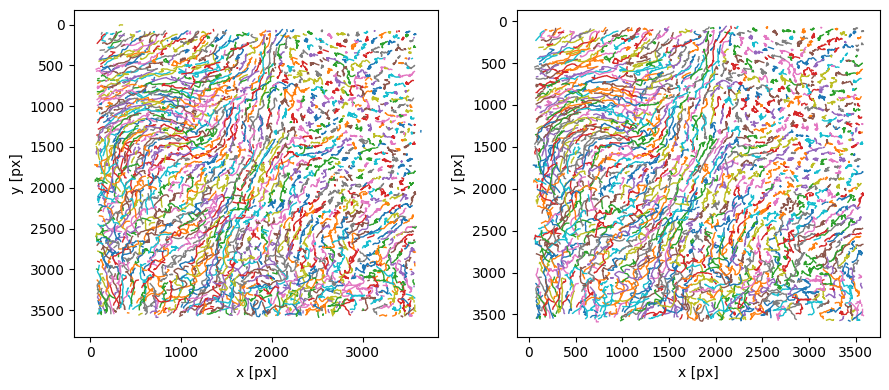

In [5]:
tracks_raw = tp.link(df[df.frame < max_frame], search_range=50, memory=5)
tracks = tp.filter_stubs(tracks_raw, 5)
tracks = tracks.reset_index(drop=True)

fig, ax = plt.subplots(1,2, figsize=(9,4))
tp.plot_traj(tracks_raw, ax=ax[0])
tp.plot_traj(tracks, ax=ax[1])
fig.tight_layout()

In [6]:
dist = []

for f in range(np.max(tracks.frame)):
    dist_tmp = tracks.sort_values(by=['particle', 'frame'])
    dx = dist_tmp.groupby('particle')['x'].diff()
    dy = dist_tmp.groupby('particle')['y'].diff()

    dist.append(np.sqrt(dx**2 + dy**2).values)
dist = np.concatenate(dist)

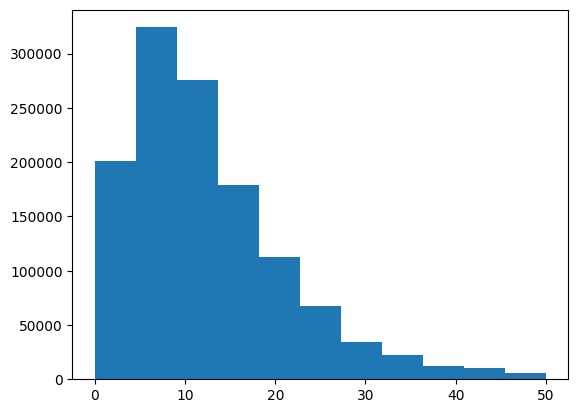

In [7]:
plt.hist(dist, bins=11);

In [8]:
min_len = 30
particles = []
track_len = []

for p in range(max(tracks.particle)):
    particles.append(p)
    track_len.append(sum(tracks.particle==p))

particles = np.array(particles)
track_len = np.array(track_len)

track_mask = particles[track_len >= min_len]
print(len(track_mask))

556


In [9]:
median_lim = 0.5
diff_lim = 0.3

good_tracks = []
for p in track_mask:
    mask = (tracks.particle == p)

    not_outlier = (abs(tracks[mask].V - np.median(tracks[mask].V)) <= median_lim*np.median(tracks[mask].V))
    dA = abs(np.diff(tracks[mask][not_outlier].A) / (tracks[mask][not_outlier].A[1:]))#+tracks[mask].A[:-1])))
    dh = abs(np.diff(tracks[mask][not_outlier].h_avrg) / (tracks[mask][not_outlier].h_avrg[1:]))#+tracks[mask].A[:-1])))
    mask2 = (dA.values <= diff_lim)*(dh.values <= diff_lim)

    if np.sum(mask2) == len(mask2) and sum(not_outlier) >= min_len:
        good_tracks.append(p)

In [10]:
len(good_tracks)

168

In [18]:
A_decrease = [2, 5, 12, 18, 24, 20, 23, 24, 25, 30, 44, 46, 57, 59, 86, 98, 103]
A_increase = [3, 4, 9, 10, 14, 16, 17, 21, 34, 38, 39, 42, 45, 48, 50, 51, 52, 56, 60, 62, 63, 64, 65, 66, 69, 71, 72, \
               73, 75, 78, 89, 80, 83, 84, 85, 87, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 105, 106, 107, 108, \
               109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130] # 117
A_fluct =  [1, 6, 7, 8, 11, 13, 15, 19, 22, 26, 27, 28, 29, 32, 36, 37, 40, 41, 47, 49, 53, 54, 55, 58, 61, 67, 68, 70, 74, 76, 77, 81, 82, 88, 89, 90, 93, 112, 126] # 0

plot_mask = np.concatenate([np.random.choice(A_decrease, 9, replace=False), np.random.choice(A_increase, 9, replace=False), np.random.choice(A_fluct, 9, replace=False)])
plot_mask = np.sort(plot_mask)
plot_mask

array([  1,   2,   5,  11,  12,  16,  17,  19,  24,  24,  29,  30,  52,
        57,  68,  70,  73,  76,  78,  86,  88,  93, 102, 103, 109, 115,
       123])

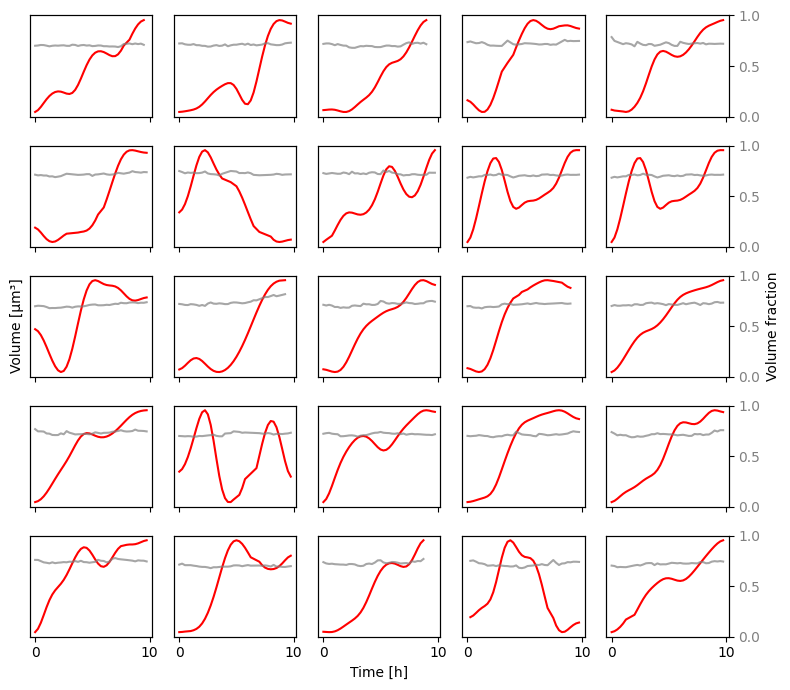

In [23]:
#[6, 17, 91]
fig, axes = plt.subplots(5,5, figsize=(8,7), sharex=True)#, sharey=True)
n0 = 1.33
nd = 1.4

i = 0
for ax in axes.flatten():
    mask = tracks.particle == good_tracks[plot_mask[i]]

    
    while np.sum(mask) == 0:
        mask = tracks.particle == good_tracks[plot_mask[i]]
        i += 1

    ax1 = ax.twinx()
    ax1.set(ylim=(0,1))
    #ax.set(ylim=(0,2500*0.0065))
    #ax.set_xticks([0, 5, 10])
    ax.tick_params(axis='y', labelcolor='k')
    ax1.tick_params(axis='y', labelcolor='gray')
    ax.set_yticks([])

    outlier = (abs(tracks[mask].V - np.median(tracks[mask].V)) <= median_lim*np.median(tracks[mask].V))
    #ax.plot(tracks[mask][outlier].frame / 4, (tracks[mask][outlier].V), 'k.', ms=3)
    mu = gaussian_filter(tracks[mask][outlier].V, sigma=3)
    ax.plot(tracks[mask][outlier].frame / 4, mu, 'r-')

    # plot dry mass
    v_frac = (tracks[mask][outlier].n_avrg - n0) / (nd - n0)
    ax1.plot(tracks[mask][outlier].frame / 4, (v_frac), '-', color="gray", ms=2, alpha=0.7)
    
    if (i+1)%5 != 0:
        ax1.set_yticks([])
    if i==14:
        ax1.set(ylabel="Volume fraction")

    i += 1

# for i in range(3):
#     axes[1,i].set(xlabel="time [h]")

# for i in range(2):
#     axes[i,0].set(ylabel="Area")

axes[2,0].set(ylabel="Volume [µm³]")#, ylim=(0, 5e3))
axes[4,2].set(xlabel="Time [h]")
fig.tight_layout()

In [17]:
#plot_mask = [2, 4, 5, 7, 8, 9, 12, 15, 16, 17, 20, 21, 22, 24, 27, 28, 30, 24]
fig.savefig(f"../../figs/volume/volume_fluctuations.png", dpi=300)

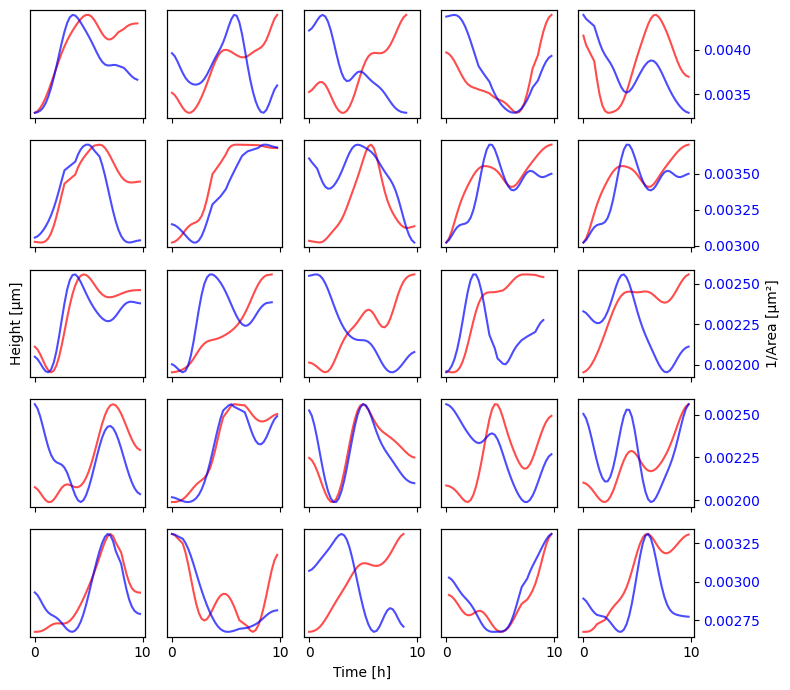

In [27]:
#[6, 17, 91]
fig, axes = plt.subplots(5,5, figsize=(8,7), sharex=True)#, sharey=True)

i = 0
idx = 0
for ax in axes.flatten():
    #mask = (tracks.particle == good_tracks[i+idx])
    mask = tracks.particle == good_tracks[plot_mask[i]]
    
    while np.sum(mask) == 0:
        #mask = (tracks.particle == good_tracks[i+idx])
        mask = tracks.particle == good_tracks[plot_mask[i]]
        i += 1

    ax1 = ax.twinx()
    ax.set_yticks([])
    # ax1.set(ylim=(0,0.0065))
    # ax.set_xticks([0, 5, 10])
    # ax.set(ylim=(0,2500*0.0065))
    ax.tick_params(axis='y', labelcolor='r')
    ax1.tick_params(axis='y', labelcolor='b')

    #ax.set(title=f"{i+idx}")

    outlier = (abs(tracks[mask].V - np.median(tracks[mask].V)) <= median_lim*np.median(tracks[mask].V))

    mu_h = gaussian_filter(tracks[mask][outlier].h_avrg, sigma=3)
    #ax.plot(tracks[mask][outlier].frame / 4, (tracks[mask][outlier].h_avrg), 'r.', ms=3)
    ax.plot(tracks[mask][outlier].frame / 4, mu_h, 'r-', alpha=0.7)

    mu_A = gaussian_filter(1/tracks[mask][outlier].A, sigma=3)
    #ax1.plot(tracks[mask][outlier].frame / 4, 1/(tracks[mask][outlier].A), 'b.', ms=3)
    ax1.plot(tracks[mask][outlier].frame / 4, mu_A, 'b-', alpha=0.7)


    if (i+1)%5 != 0:
        ax1.set_yticks([])
    if i==14:
        ax1.set(ylabel="1/Area [µm²]")

    i += 1

axes[2,0].set(ylabel="Height [µm]")
axes[4,2].set(xlabel="Time [h]")
fig.tight_layout()

In [15]:
fig.savefig(f"../../figs/volume/area_height_fluctuations.png", dpi=300)

In [59]:
heights = []
areas = []
volumes = []
n = []
smooth_volumes = []
smooth_areas = []
smooth_heights = []
time = []
for p in good_tracks:
    mask = tracks.particle == p

    
    while np.sum(mask) == 0:
        mask = tracks.particle == p
        i += 1

    outlier = (abs(tracks[mask].V - np.median(tracks[mask].V)) <= median_lim*np.median(tracks[mask].V))
    smooth_volumes.append(gaussian_filter(tracks[mask][outlier].V, sigma=1.5))
    smooth_areas.append(gaussian_filter(tracks[mask][outlier].A, sigma=1.5))
    smooth_heights.append(gaussian_filter(tracks[mask][outlier].h_avrg, sigma=1.5))
    volumes.append(tracks[mask][outlier].V.values)
    areas.append(tracks[mask][outlier].A.values)
    heights.append(tracks[mask][outlier].h_avrg.values)
    n.append(tracks[mask][outlier].n_avrg.values)
    time.append(tracks[mask][outlier].frame.values / 4)


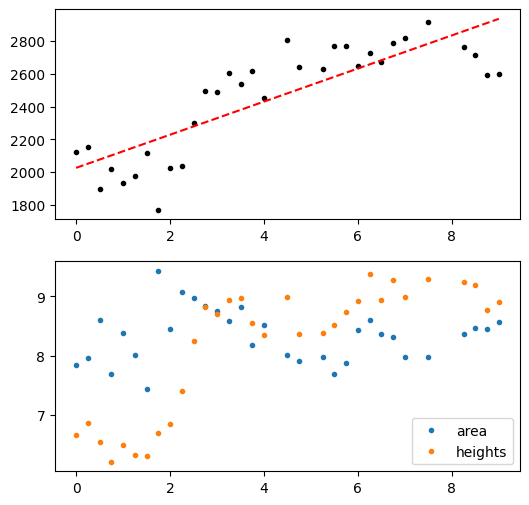

In [60]:
def func(x, a, b):
    return a*x + b

i = 57
param, cov = curve_fit(func, time[i], volumes[i])

fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(time[i], volumes[i], 'k.')
#ax[0].plot(time[i], smooth_volumes[i], 'k-', alpha=0.5)
ax[0].plot(time[i], func(time[i], *param), 'r--')

ax[1].plot(time[i], 2500/areas[i], '.', label="area")
ax[1].plot(time[i], heights[i], '.', label="heights")
ax[1].legend()


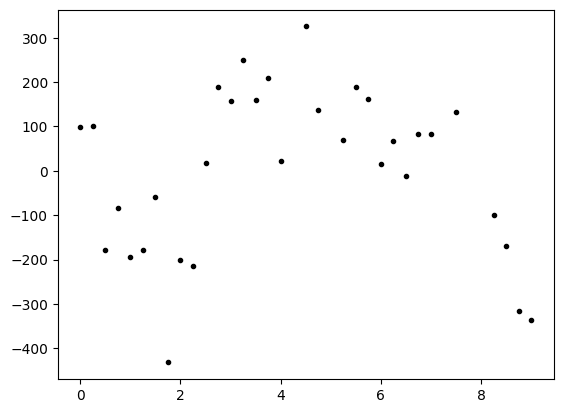

In [61]:
plt.plot(time[i], volumes[i]-func(time[i], *param), 'k.')

In [62]:
V_fluct = []
A_fluct = []
h_fluct = []
m_fluct = []
v_fluct = []

for i in range(len(volumes)):
    param, cov = curve_fit(func, time[i], volumes[i])
    V_fluct.append(np.std(volumes[i]-func(time[i], *param)) / np.mean(volumes[i]))
    #V_fluct.append(np.std(volumes[i]) / np.mean(volumes[i]))

    param, cov = curve_fit(func, time[i], areas[i])
    A_fluct.append(np.std(areas[i]-func(time[i], *param)) / np.mean(areas[i]))
    #A_fluct.append(np.std(areas[i]) / np.mean(areas[i]))

    param, cov = curve_fit(func, time[i], heights[i])
    h_fluct.append(np.std(heights[i]-func(time[i], *param)) / np.mean(heights[i]))
    #h_fluct.append(np.std(heights[i]) / np.mean(heights[i]))

    v = (np.array(n[i])-1.33) / (1.4-1.33)
    param, cov = curve_fit(func, time[i], v)
    #v_fluct.append(np.std(v-func(time[i], *param)) / np.mean(v))
    v_fluct.append(np.std(v) / np.mean(v))


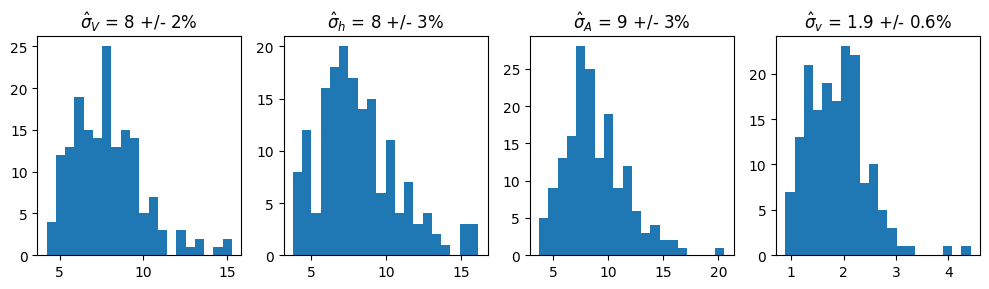

In [63]:
fig, ax = plt.subplots(1,4, figsize=(10,3))

ax[0].hist(np.array(V_fluct)*100, bins=20)
ax[0].set(title=rf"$\hat{{\sigma}}_V$ = {np.mean(V_fluct)*100:0.0f} +/- {np.std(V_fluct)*100:0.0f}%")

ax[1].hist(np.array(h_fluct)*100, bins=20)
ax[1].set(title=rf"$\hat{{\sigma}}_h$ = {np.mean(h_fluct)*100:0.0f} +/- {np.std(h_fluct)*100:0.0f}%")

ax[2].hist(np.array(A_fluct)*100, bins=20)
ax[2].set(title=rf"$\hat{{\sigma}}_A$ = {np.mean(A_fluct)*100:0.0f} +/- {np.std(A_fluct)*100:0.0f}%")
ax[3].hist(np.array(v_fluct)*100, bins=20)
ax[3].set(title=rf"$\hat{{\sigma}}_{{v}}$ = {np.mean(v_fluct)*100:0.1f} +/- {np.std(v_fluct)*100:0.1f}%")

fig.tight_layout()
fig.savefig("nice_tracks_fluctuations.png", dpi=300)

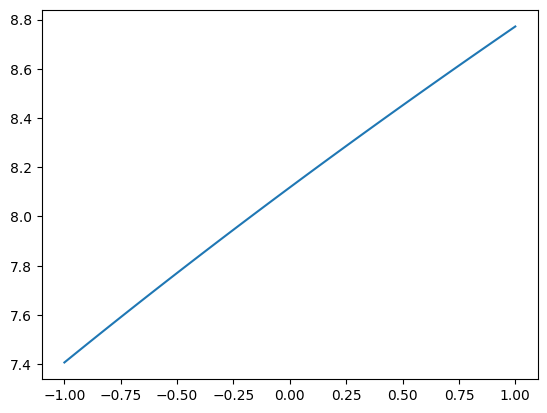

In [21]:
x = np.linspace(-1, 1, 100)

def sigma_Vd(sigma_n, sigma_V, x):
    n = 1.38
    n0 = 1.33
    return np.sqrt((n*sigma_n/(n-n0))**2 + sigma_V**2 + n*sigma_V*sigma_n*x/(n-n0))

plt.plot(x, sigma_Vd(0.05, 8, x))

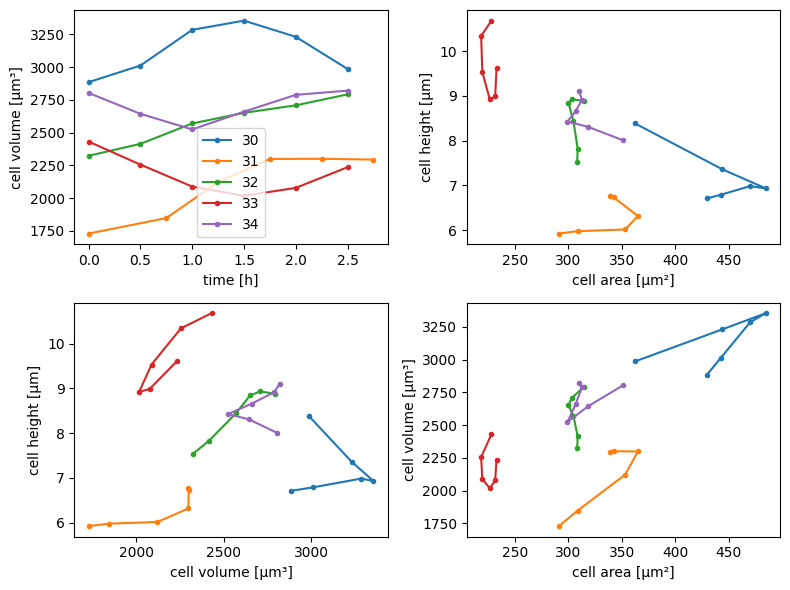

In [22]:
def norm(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

fig, ax = plt.subplots(2,2, figsize=(8,6))

t0 = 0
tf = 12
step = 2

increase = [4, 1, 0, 8, 6]
const = [2, 7, 55, 56, 57, 54, 61, 79, 95]
for i in range(30,35):
    param, cov = curve_fit(func, time[i], smooth_volumes[i])
    v = (smooth_volumes[i])[t0:tf:step]# - func(time[i], *param)) / np.mean(smooth_volumes[i])

    param, cov = curve_fit(func, time[i], smooth_heights[i])
    h = (smooth_heights[i])[t0:tf:step]# - func(time[i], *param)) / np.mean(smooth_heights[i])

    param, cov = curve_fit(func, time[i], smooth_areas[i])
    a = (smooth_areas[i])[t0:tf:step]# - func(time[i], *param)) / np.mean(smooth_areas[i])

    ax[0,0].plot(time[i][t0:tf:step],  v,   '.-', label=str(i))
    ax[0,1].plot(a, h, '.-')
    ax[1,0].plot(v, h, '.-')
    ax[1,1].plot(a, v, '.-')


ax[0,0].set(xlabel="time [h]", ylabel="cell volume [µm³]")
ax[0,1].set(xlabel="cell area [µm²]", ylabel="cell height [µm]")
ax[1,0].set(xlabel="cell volume [µm³]", ylabel="cell height [µm]")
ax[1,1].set(xlabel="cell area [µm²]", ylabel="cell volume [µm³]")

fig.tight_layout()
ax[0,0].legend()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

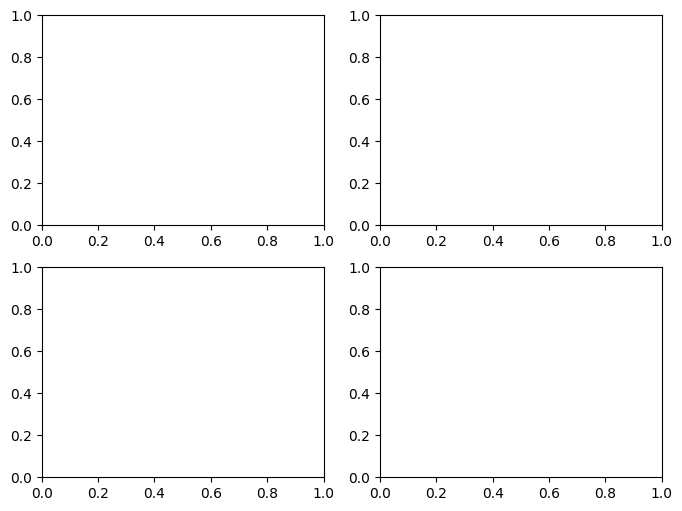

In [23]:
def norm(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

fig, ax = plt.subplots(2,2, figsize=(8,6))

t0 = 0
tf = 12
step = 2

v = (smooth_volumes[i])[:,t0:tf:step]
a = (smooth_areas[i])[:,t0:tf:step]
h = (smooth_heights[i])[:,t0:tf:step]

mask = (v - np.mean(v, axis=0) < 0.1)
for i in range(50,60):
    param, cov = curve_fit(func, time[i], smooth_volumes[i])
    v = (smooth_volumes[i])[t0:tf:step]# - func(time[i], *param)) / np.mean(smooth_volumes[i])

    param, cov = curve_fit(func, time[i], smooth_heights[i])
    h = (smooth_heights[i])[t0:tf:step]# - func(time[i], *param)) / np.mean(smooth_heights[i])

    param, cov = curve_fit(func, time[i], smooth_areas[i])
    a = (smooth_areas[i])[t0:tf:step]# - func(time[i], *param)) / np.mean(smooth_areas[i])

    ax[0,0].plot(time[i][t0:tf:step],  v,   '.-')
    ax[0,1].plot(a, h, '.-')
    ax[1,0].plot(v, h, '.-')
    ax[1,1].plot(a, v, '.-')


ax[0,0].set(xlabel="time [h]", ylabel="cell volume [µm³]")
ax[0,1].set(xlabel="cell area [µm²]", ylabel="cell height [µm]")
ax[1,0].set(xlabel="cell volume [µm³]", ylabel="cell height [µm]")
ax[1,1].set(xlabel="cell area [µm²]", ylabel="cell volume [µm³]")

fig.tight_layout()


In [ ]:
# for all tracks
heights = []
areas = []
volumes = []
smooth_volumes = []
time = []
for p in range(max(tracks.particle)):
    mask = tracks.particle == p

    
    while np.sum(mask) == 0:
        mask = tracks.particle == p
        i += 1

    outlier = (abs(tracks[mask].V - np.median(tracks[mask].V)) <= median_lim*np.median(tracks[mask].V))
    smooth_volumes.append(gaussian_filter(tracks[mask][outlier].V, sigma=1.5))
    volumes.append(tracks[mask][outlier].V.values)
    areas.append(tracks[mask][outlier].A.values)
    heights.append(tracks[mask][outlier].h_avrg.values)
    time.append(tracks[mask][outlier].frame.values / 4)


In [ ]:
len(heights)